**This notebook evalutes the effectiveness of PixelDefend against adversarial attacks on the CIFAR-10 dataset.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import PixelDefend
# from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, PyTorchClassifier
from art.utils import load_cifar10

In [4]:
!pip freeze > '/home/cyber/Desktop/Adrian/snapshot.txt'

### Create PixelCNN for PixelDefend

*Note: Load PyTorch before disabling eager execution to optimize CUDA memory*

#### Load PyTorch prerequisites

In [2]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
# import torchvision
# from torchvision import datasets, utils, transforms
# from torch.autograd import Variable
# from torch.nn.utils import weight_norm as wn
# from torch.utils.data import Dataset, DataLoader

#### Create PixelCNN classifier

*Define PixelCNN architecture*

In [3]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, c_in, c_out, k_size, stride, pad):
        """2D Convolution with masked weight for Autoregressive connection"""
        super(MaskedConv2d, self).__init__(
            c_in, c_out, k_size, stride, pad, bias=False)
        assert mask_type in ['A', 'B']
        self.mask_type = mask_type
        ch_out, ch_in, height, width = self.weight.size()

        # Mask
        #         -------------------------------------
        #        |  1       1       1       1       1 |
        #        |  1       1       1       1       1 |
        #        |  1       1    1 if B     0       0 |   H // 2
        #        |  0       0       0       0       0 |   H // 2 + 1
        #        |  0       0       0       0       0 |
        #         -------------------------------------
        #  index    0       1     W//2    W//2+1

        mask = torch.ones(ch_out, ch_in, height, width)
        if mask_type == 'A':
            # First Convolution Only
            # => Restricting connections to
            #    already predicted neighborhing channels in current pixel
            mask[:, :, height // 2, width // 2:] = 0
            mask[:, :, height // 2 + 1:] = 0
        else:
            mask[:, :, height // 2, width // 2 + 1:] = 0
            mask[:, :, height // 2] = 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


def maskAConv(c_in=3, c_out=256, k_size=7, stride=1, pad=3):
    """2D Masked Convolution (type A)"""
    return nn.Sequential(
        MaskedConv2d('A', c_in, c_out, k_size, stride, pad),
        nn.BatchNorm2d(c_out))


class MaskBConvBlock(nn.Module):
    def __init__(self, h=128, k_size=3, stride=1, pad=1):
        """1x1 Conv + 2D Masked Convolution (type B) + 1x1 Conv"""
        super(MaskBConvBlock, self).__init__()

        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),  # 1x1
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, k_size, stride, pad),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),  # 1x1
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        """Residual connection"""
        return self.net(x) + x

In [4]:
class PixelCNN(nn.Module):
    def __init__(self, n_channel=3, h=128, discrete_channel=256):
        """PixelCNN Model"""
        super(PixelCNN, self).__init__()

        self.discrete_channel = discrete_channel

        self.MaskAConv = maskAConv(n_channel, 2 * h, k_size=7, stride=1, pad=3)
        MaskBConv = []
        for i in range(15):
            MaskBConv.append(MaskBConvBlock(h, k_size=3, stride=1, pad=1))
        self.MaskBConv = nn.Sequential(*MaskBConv)

        # 1x1 conv to 3x256 channels
        self.out = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, 1024, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, n_channel * discrete_channel, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        """
        Args:
            x: [batch_size, channel, height, width]
        Return:
            out [batch_size, channel, height, width, 256]
        """
        batch_size, c_in, height, width = x.size()

        # [batch_size, 2h, 32, 32]
        x = self.MaskAConv(x)

        # [batch_size, 2h, 32, 32]
        x = self.MaskBConv(x)

        # [batch_size, 3x256, 32, 32]
        x = self.out(x)

        # [batch_size, 3, 256, 32, 32]
        x = x.view(batch_size, c_in, self.discrete_channel, height, width)

        # [batch_size, 3, 32, 32, 256]
        x = x.permute(0, 1, 3, 4, 2)

        return x

*Load the weights of a CIFAR-10 pre-trained PixelCNN*

In [5]:
model = PixelCNN()

*Create PixelCNN classifier*

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
pixelcnn = PyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=10,clip_values=(0, 1)
)

### **Disable eager execution to enable adversarial crafting and ART classifier**

In [7]:
tf.compat.v1.disable_eager_execution()

### **Load CIFAR-10 dataset**

In [8]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_cifar10()
# x_test_cln, y_test_cln = x_test_cln[:1000], y_test_cln[:100]

### **Create CIFAR-10 classifier model**

*Load CIFAR-10 pre-trained model*

In [9]:
model = load_model("/home/cyber/Desktop/Adrian/cifar10_trained_model.h5")

*Create ART classifier*

In [10]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [11]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on clean test examples: 88.87%


Step 2: Split the clean test set into its true and false positives

In [12]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Number of clean true positives: 8887
Number of clean false positives: 1113


Step 3: Craft adversarial examples

*Craft Jacobian-based Saliency Map Attack (JSMA) attacks*

In [13]:
# attack = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_cifar10 = attack.generate(x_test_cln)
# %store x_test_JSMA_cifar10

*Craft Basic Iterative Method (BMI) attacks*

In [14]:
# attack = BasicIterativeMethod(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_BIM_cifar10 = attack.generate(x_test_cln)
# %store x_test_BIM_cifar10

*Craft Projected Gradient Descent (PGD) attacks*

In [15]:
# attack = ProjectedGradientDescent(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_PGD_cifar10 = attack.generate(x_test_cln)
# %store x_test_PGD_cifar10

*Craft NewtonFool attacks*

In [16]:
# attack = NewtonFool(classifier=classifier, eta=0.005, max_iter=25, verbose=True)
# x_test_Newton_cifar10 = attack.generate(x_test_cln)
# %store x_test_Newton_cifar10

*Craft DeepFool attacks*

In [17]:
# attack = DeepFool(classifier=classifier, epsilon=1e-06/255, max_iter=50)
# x_test_Deep_cifar10 = attack.generate(x_test_cln)
# %store x_test_Deep_cifar10

*Alternatively, load existing adversarial attacks*

In [18]:
attack_name = 'JSMA'
%store -r x_test_JSMA_cifar10
x_test_adv = x_test_JSMA_cifar10

Step 4: Evaluate the classifier on the adversarial test set

In [19]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 1.3%


Step 5: Split the adversarial test set into its true and false positives

In [20]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 130
Adversarial FP: 9870


Step 6: Plot clean test examples and their adversarial counterparts

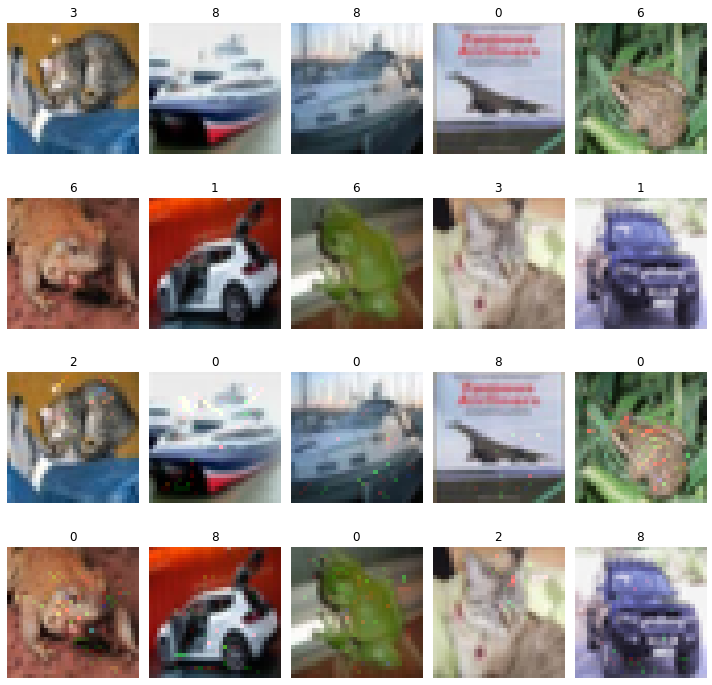

In [21]:
# Plot images
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **PixelDefend**

Step 1: Transform input

*Pre-process input for PixelDefend*

In [22]:
x_test_cln_tp_pre = np.transpose(x_test_cln_tp, (0, -1, 1, 2))
x_test_cln_fp_pre = np.transpose(x_test_cln_fp, (0, -1, 1, 2))

In [23]:
x_test_adv_tp_pre = np.transpose(x_test_adv_tp, (0, -1, 1, 2))
x_test_adv_fp_pre = np.transpose(x_test_adv_fp, (0, -1, 1, 2))

*Transform input*

In [24]:
defence = PixelDefend(eps=16, pixel_cnn=pixelcnn, verbose=True)

In [25]:
x_test_cln_tp_pre_pd = defence(x_test_cln_tp_pre * 255)[0] / 255
x_test_cln_fp_pre_pd = defence(x_test_cln_fp_pre * 255)[0] / 255
x_test_cln_pre_pd = np.concatenate((x_test_cln_tp_pre_pd, x_test_cln_fp_pre_pd), axis=0)
y_test_cln_pd = y_test_cln_tp + y_test_cln_fp

RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 7.93 GiB total capacity; 259.48 MiB already allocated; 30.62 MiB free; 280.00 MiB reserved in total by PyTorch)

In [ ]:
x_test_adv_tp_pre_pd = defence(x_test_adv_tp_pre * 255)[0] / 255
x_test_adv_fp_pre_pd = defence(x_test_adv_fp_pre * 255)[0] / 255
x_test_adv_pre_pd = np.concatenate((x_test_adv_tp_pre_pd, x_test_adv_fp_pre_pd), axis=0)
y_test_adv_pd = y_test_adv_tp + y_test_adv_fp

*Post-process output for classification and plotting*

In [ ]:
x_test_cln_pd = np.transpose(x_test_cln_pre_pd, (0, 2, -1, 1))
x_test_cln_tp_pd = np.transpose(x_test_cln_tp_pre_pd, (0, 2, -1, 1))
x_test_cln_fp_pd = np.transpose(x_test_cln_fp_pre_pd, (0, 2, -1, 1))

In [ ]:
x_test_adv_pd = np.transpose(x_test_adv_pre_pd, (0, 2, -1, 1))
x_test_adv_tp_pd = np.transpose(x_test_adv_tp_pre_pd, (0, 2, -1, 1))
x_test_adv_fp_pd = np.transpose(x_test_adv_fp_pre_pd, (0, 2, -1, 1))

Step 2: Evaluate the classifier on all 4 sets of data after PixelDefend

In [ ]:
predictions_cln_pd = classifier.predict(x_test_cln_pd)
accuracy_cln_pd = np.sum(np.argmax(predictions_cln_pd, axis=1) == np.argmax(y_test_cln_pd, axis=1)) / len(y_test_cln)

print("Effect of PixelDefend on entire clean test set: {:.2f}%".format((accuracy_cln_pd - accuracy_cln) * 100))
 
predictions_cln_tp_pd = classifier.predict(x_test_cln_tp_pd)
accuracy_cln_tp_pd = np.sum(np.argmax(predictions_cln_tp_pd, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_tp_pd * 100))
print("\nAccuracy drop on true positive clean test examples after PixelDefend: {:.2f}%".format((1 - accuracy_cln_tp_pd) * 100))

predictions_cln_fp_pd = classifier.predict(x_test_cln_fp_pd)
accuracy_cln_fp_pd = np.sum(np.argmax(predictions_cln_fp_pd, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_fp_pd * 100))

predictions_adv_pd = classifier.predict(x_test_adv_pd)
accuracy_adv_pd = np.sum(np.argmax(predictions_adv_pd, axis=1) == np.argmax(y_test_adv_pd, axis=1)) / len(y_test_cln)

print("\nEffect of PixelDefend on entire adversarial test set: {:.2f}%".format((accuracy_adv_pd-accuracy_adv) * 100))

predictions_adv_tp_pd = classifier.predict(x_test_adv_tp_pd)
accuracy_adv_tp_pd = np.sum(np.argmax(predictions_adv_tp_pd, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_tp_pd * 100))
print("\nAccuracy drop on true positive adversarial test examples after PixelDefend: {:.2f}%".format((1 - accuracy_adv_tp_pd) * 100))

predictions_adv_fp_pd = classifier.predict(x_test_adv_fp_pd)
accuracy_adv_fp_pd = np.sum(np.argmax(predictions_adv_fp_pd, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_fp_pd * 100))

Step 3: Plot all data pre- and post-transformation

In [ ]:
# Get index of succepdful Spatial Smoothing transformations
succ_cln_tp_idx=[]
succ_cln_fp_idx=[]
succ_adv_tp_idx=[]
succ_adv_fp_idx=[]


for k in range(len(predictions_cln_tp_pd)):
    if(np.argmax(predictions_cln_tp_pd, axis=1)[k] == np.argmax(y_test_cln_tp, axis=1)[k]):
        succ_cln_tp_idx.append(k)
        
for k in range(len(predictions_cln_fp_pd)):
    if(np.argmax(predictions_cln_fp_pd, axis=1)[k] == np.argmax(y_test_cln_fp, axis=1)[k]):
        succ_cln_fp_idx.append(k)
        
for k in range(len(predictions_adv_tp_pd)):
    if(np.argmax(predictions_adv_tp_pd, axis=1)[k] == np.argmax(y_test_adv_tp, axis=1)[k]):
        succ_adv_tp_idx.append(k)
        
for k in range(len(predictions_adv_fp_pd)):
    if(np.argmax(predictions_adv_fp_pd, axis=1)[k] == np.argmax(y_test_adv_fp, axis=1)[k]):
        succ_adv_fp_idx.append(k)
        
# Get predictions of data before transformation

predictions_cln_tp = clapdifier.predict(x_test_cln_tp)
predictions_cln_fp = clapdifier.predict(x_test_cln_fp)
predictions_adv_tp = clapdifier.predict(x_test_adv_tp)
predictions_adv_fp = clapdifier.predict(x_test_adv_fp)

#plot images
plt.figure(figsize=(24,18))

#Plot clean true positives
ax = plt.subplot(2, 4, 1)
plt.imshow(x_test_cln_tp[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 1+4)
plt.imshow(x_test_cln_tp_pd[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP after Spatial Smoothing: {:}'.format(np.argmax(predictions_cln_tp_pd,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot clean false positives
ax = plt.subplot(2, 4, 2)
plt.imshow(x_test_cln_fp[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP: {:}\nTrue clapd: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 2+4)
plt.imshow(x_test_cln_fp_pd[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP after Spatial Smoothing: {:}\nTrue clapd: {:}'.format(np.argmax(predictions_cln_fp_pd,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(2, 4, 3)
plt.imshow(x_test_adv_tp[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 3+4)
plt.imshow(x_test_adv_tp_pd[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP after Spatial Smoothing: {:}'.format(np.argmax(predictions_adv_tp_pd,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(2, 4, 4)
plt.imshow(x_test_adv_fp[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue clapd: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 4+4)
plt.imshow(x_test_adv_fp_pd[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP after Spatial Smoothing: {:}\nTrue clapd: {:}'.format(np.argmax(predictions_adv_fp_pd,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

image_path = '/home/cyber/Desktop/Adrian/Plots/SpatialSmoothing_CIFAR-10_{:}.png'.format(attack_name)
plt.savefig(image_path, dpi=500, transparent=True)
plt.tight_layout()
plt.show()

## Others

Optional step: Compare the performance of PixelDefend against the adversary over a range of eps values

In [ ]:
# eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracy_original = []
# accuracy_robust = []

# attack = FastGradientMethod(classifier)
# attack_robust = FastGradientMethod(robust_classifier)

# for eps in eps_range:
#     attack.set_params(**{'eps': eps})
#     attack_robust.set_params(**{'eps': eps})
#     x_test_adv = attack.generate(x_test[:100])
#     x_test_adv_robust = attack_robust.generate(x_test[:100])
    
#     predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
#     accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
#     predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
#     accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

# eps_range = eps_range

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
# ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
# #legend.get_frame().set_facecolor('#00FFCC')

# plt.xlabel('Attack strength (eps)')
# plt.ylabel('Accuracy (%)')
# plt.show()

## PixelCNN

### Attempt 1

In [ ]:
def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


In [ ]:
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        self.fc = nn.Linear(28*28, 28*28*64)

    def forward(self, x):
        x = x.view(-1, 28*28)
        logit_output = self.fc(x)
        logit_output = logit_output.view(-1, 64, 1, 28, 28)

        return logit_output

### Attempt 2: PixelCNN by Jzbontar

In [ ]:
device = torch.device("cuda")

In [ ]:
print('torch.cuda.is_available():', torch.cuda.is_available())

In [ ]:
import os
import time
import sys

from torch import nn, optim, cuda, backends
from torch.utils import data
backends.cudnn.benchmark = True


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

fm = 64
model = nn.Sequential(
    MaskedConv2d('A', 1,  fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    nn.Conv2d(fm, 256, 1))
model.eval()
model = model.to(device)

tr = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
te = data.DataLoader(datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=False, num_workers=1, pin_memory=True)
sample = torch.Tensor(144, 1, 28, 28).cuda()
optimizer = optim.Adam(model.parameters())
# for epoch in range(5):
#     # train
#     err_tr = []
#     cuda.synchronize()
#     time_tr = time.time()
#     model.train(True)
#     for input, _ in tr:
#         input = Variable(input.cuda(non_blocking=True))
#         target = Variable((input.data[:,0] * 255).long())
#         loss = F.cross_entropy(model(input), target)
#         err_tr.append(loss.data.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     cuda.synchronize()
#     time_tr = time.time() - time_tr

#     # compute error on test set
#     err_te = []
#     cuda.synchronize()
#     time_te = time.time()
#     model.train(False)
#     for input, _ in te:
#         input = Variable(input.cuda(non_blocking=True), volatile=True)
#         target = Variable((input.data[:,0] * 255).long())
#         loss = F.cross_entropy(model(input), target)
#         err_te.append(loss.data.item())
#     cuda.synchronize()
#     time_te = time.time() - time_te

#     # sample
#     sample.fill_(0)
#     model.train(False)
#     for i in range(28):
#         for j in range(28):
#             out = model(Variable(sample, volatile=True))
#             probs = F.softmax(out[:, :, i, j]).data
#             sample[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.
#     utils.save_image(sample, 'sample_{:02d}.png'.format(epoch), nrow=12, padding=0)

#     print('epoch={}; nll_tr={:.7f}; nll_te={:.7f}; time_tr={:.1f}s; time_te={:.1f}s'.format(
#         epoch, np.mean(err_tr), np.mean(err_te), time_tr, time_te))

### Attempt 3: PixelCNN by Kamenbliznashki

In [ ]:
"""
PixelCNN implementation
References:
    1. van den Oord, Pixel Recurrent Neural Networks 2016a
    2. van den Oord, Conditional Image Generation with PixelCNN Decoders, 2016c
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

image_dims=(1,32,32) 
n_bits=4
n_channels=128
n_out_conv_channels=1024
kernel_size=5
n_res_layers=12
n_cond_classes=10


# --------------------
# Model components
# --------------------

def pixelcnn_gate(x):
    a, b = x.chunk(2,1)
    return torch.tanh(a) * torch.sigmoid(b)

class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type=None, mask_n_channels=None, gated=False, **kwargs):
        super().__init__(*args, **kwargs)
#         nn.init.constant_(bias, 0.)

        # set up mask -- cf PixelRNN paper Figure 2 Right: masks A and B
        mask_type = mask_type
        mask_n_channels = mask_n_channels
        center_row = kernel_size[0] // 2
        center_col = kernel_size[1] // 2

        mask = torch.ones_like(weight)         # shape (out_channels, in_channels, kernel_height, kernel_width)

        # mask out 1/ rows below the middle and 2/ center row pixels right of middle
        if center_row == 0:                         # case when kernel_size = (1,k) in horizontal stack
            mask[:, :, :, center_col+1:] = 0
        elif center_col == 0:                       # case when kernel_size = (k,1)
            mask[:, :, center_row+1:, :] = 0
        else:                                       # case when kernel_size = (k,k)
            mask[:, :, center_row+1:, :] = 0
            mask[:, :, center_row, center_col+1:] = 0

        # mask out center pixel in future channels -- mask A current channel is 0; mask B current channel is 1
        for i in range(mask_n_channels):
            for j in range(mask_n_channels):
                if (mask_type=='a' and i >= j) or (mask_type=='b' and i > j):
                    mask[j::mask_n_channels, i::mask_n_channels, center_row, center_col] = 0

        # mask out center row (vertical stack in a Gated Residual Layer); cf Conditional image generation with PixelCNN Decoders
        if mask_type == 'vstack':
            mask[:, :, center_row, :] = 0

        if gated:
            # pixelcnn gate splits the input in two along the channel dim;
            # ensure that both chunks receive the same mask by replicating the first half of the mask over the second
            mask = mask.chunk(2,0)[0].repeat(2,1,1,1)

        # final mask
        register_buffer('mask', mask)

    def forward(self, x):
        weight.data *= mask
        return super().forward(x)

    def __repr__(self):
        s = super().__repr__()
        return s[:-1] + ', mask_type={}, mask_n_channels={}'.format(mask_type, mask_n_channels) + s[-1]


class GatedResidualLayer(nn.Module):
    """ Figure 2 in Conditional image generation with PixelCNN Decoders """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, mask_n_channels, n_cond_classes, norm_layer):
        super().__init__()
        residual = (in_channels==out_channels)
        norm_layer = norm_layer

        v   = MaskedConv2d(in_channels, 2*out_channels, kernel_size, padding=kernel_size//2,
                                mask_type='vstack', mask_n_channels=mask_n_channels, gated=True)
        h   = MaskedConv2d(in_channels, 2*out_channels, (1, kernel_size), padding=(0, kernel_size//2),
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        v2h = MaskedConv2d(2*out_channels, 2*out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=True)
        h2h = MaskedConv2d(out_channels, out_channels, kernel_size=1,
                                mask_type=mask_type, mask_n_channels=mask_n_channels, gated=False)

        if n_cond_classes:
            proj_h = nn.Linear(n_cond_classes, 2*out_channels)

        if norm_layer:
            norm_layer_v = nn.BatchNorm2d(out_channels)
            norm_layer_h = nn.BatchNorm2d(out_channels)

    def forward(self, x_v, x_h, h=None):
        # projection of h if included for conditional generation (cf paper section 2.3 -- added before the pixelcnn_gate)
        proj_y = proj_h(h)[:,:,None,None] if h is not None else 0

        # vertical stack
        x_v_out = v(x_v)
        x_v2h = v2h(x_v_out) + proj_y
        x_v_out = pixelcnn_gate(x_v_out)

        # horizontal stack
        x_h_out = h(x_h) + x_v2h + proj_y
        x_h_out = pixelcnn_gate(x_h_out)
        x_h_out = h2h(x_h_out)

        # residual connection
        if residual:
            x_h_out = x_h_out + x_h

        # normalization
        if norm_layer:
            x_v_out = norm_layer_v(x_v_out)
            x_h_out = norm_layer_h(x_h_out)

        return x_v_out, x_h_out

    def extra_repr(self):
        return 'residual={}, norm_layer={}'.format(residual, norm_layer)


# --------------------
# PixelCNN
# --------------------

class PixelCNN(nn.Module):
    def __init__(self, image_dims, n_bits, n_channels, n_out_conv_channels, kernel_size, n_res_layers, n_cond_classes, norm_layer=True):
        super().__init__()
        C, H, W = image_dims

        input_conv = MaskedConv2d(C, 2*n_channels, kernel_size=7, padding=3, mask_type='a', mask_n_channels=C, gated=True)
        res_layers = nn.ModuleList([
            GatedResidualLayer(n_channels, n_channels, kernel_size, 'b', C, n_cond_classes, norm_layer)
            for _ in range(n_res_layers)])
        conv_out1 = MaskedConv2d(n_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        conv_out2 = MaskedConv2d(n_out_conv_channels, 2*n_out_conv_channels, kernel_size=1, mask_type='b', mask_n_channels=C, gated=True)
        output = MaskedConv2d(n_out_conv_channels, C * 2**n_bits, kernel_size=1, mask_type='b', mask_n_channels=C)

        if n_cond_classes:
            proj_h = nn.Linear(n_cond_classes, 2*n_channels)

    def forward(self, x, h=None):
        B, C, H, W = x.shape

        x = pixelcnn_gate(input_conv(x) + (proj_h(h)[:,:,None,None] if h is not None else 0.))
        x_v, x_h = x, x

        for l in res_layers:
            x_v, x_h = l(x_v, x_h)

        out = pixelcnn_gate(conv_out1(x_h))
        out = pixelcnn_gate(conv_out2(out))
        out = output(out)

        return out.reshape(B, -1, C, H, W)

In [ ]:
model = PixelCNN(image_dims=(3,32,32), n_bits=4, n_channels=128, n_out_conv_channels=1024, kernel_size=5, n_res_layers=12, n_cond_classes=10)
# model.load_state_dict(torch.load('/home/cyber/miniconda3/envs/tf-gpu/pixel_models-master/results/pixelcnn/2021-05-04_08-44-00/checkpoint.pt'))

### Attempt 4: PixelCNN by pclucas14

In [ ]:

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    # Pytorch ordering
    axis = len(x.size()) - 3
    return F.elu(torch.cat([x, -x], dim=axis))


def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))


def discretized_mix_logistic_loss(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10) 
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))


def discretized_mix_logistic_loss_1d(x, l):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]

    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 3)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # 2 for mean, scale
    means = l[:, :, :, :, :nr_mix]
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)

    # means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))


def to_one_hot(tensor, n, fill_with=1.):
    # we perform one hot encore with respect to the last axis
    one_hot = torch.FloatTensor(tensor.size() + (n,)).zero_()
    if tensor.is_cuda : one_hot = one_hot.cuda()
    one_hot.scatter_(len(tensor.size()), tensor.unsqueeze(-1), fill_with)
    return Variable(one_hot)


def sample_from_discretized_mix_logistic_1d(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [1] #[3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # for mean, scale

    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    out = x0.unsqueeze(1)
    return out


def sample_from_discretized_mix_logistic(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3])
    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    coeffs = torch.sum(F.tanh(
        l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, dim=4)
    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    x1 = torch.clamp(torch.clamp(
       x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, min=-1.), max=1.)
    x2 = torch.clamp(torch.clamp(
       x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, min=-1.), max=1.)

    out = torch.cat([x0.view(xs[:-1] + [1]), x1.view(xs[:-1] + [1]), x2.view(xs[:-1] + [1])], dim=3)
    # put back in Pytorch ordering
    out = out.permute(0, 3, 1, 2)
    return out



''' utilities for shifting the image around, efficient alternative to masking convolutions '''
def down_shift(x, pad=None):
    # Pytorch ordering
    xs = [int(y) for y in x.size()]
    # when downshifting, the last row is removed 
    x = x[:, :, :xs[2] - 1, :]
    # padding left, padding right, padding top, padding bottom
    pad = nn.ZeroPad2d((0, 0, 1, 0)) if pad is None else pad
    return pad(x)


def right_shift(x, pad=None):
    # Pytorch ordering
    xs = [int(y) for y in x.size()]
    # when righshifting, the last column is removed 
    x = x[:, :, :, :xs[3] - 1]
    # padding left, padding right, padding top, padding bottom
    pad = nn.ZeroPad2d((1, 0, 0, 0)) if pad is None else pad
    return pad(x)


def load_part_of_model(model, path):
    params = torch.load(path)
    added = 0
    for name, param in params.items():
        if name in model.state_dict().keys():
            try : 
                model.state_dict()[name].copy_(param)
                added += 1
            except Exception as e:
                print(e)
                pass
    print('added %s of params:' % (added / float(len(model.state_dict().keys()))))

In [ ]:
class nin(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(nin, self).__init__()
        self.lin_a = wn(nn.Linear(dim_in, dim_out))
        self.dim_out = dim_out
    
    def forward(self, x):
        og_x = x
        # assumes pytorch ordering
        """ a network in network layer (1x1 CONV) """
        # TODO : try with original ordering
        x = x.permute(0, 2, 3, 1)
        shp = [int(y) for y in x.size()]
        out = self.lin_a(x.contiguous().view(shp[0]*shp[1]*shp[2], shp[3]))
        shp[-1] = self.dim_out
        out = out.view(shp)
        return out.permute(0, 3, 1, 2)


class down_shifted_conv2d(nn.Module):
    def __init__(self, num_filters_in, num_filters_out, filter_size=(2,3), stride=(1,1), 
                    shift_output_down=False, norm='weight_norm'):
        super(down_shifted_conv2d, self).__init__()
        
        assert norm in [None, 'batch_norm', 'weight_norm']
        self.conv = nn.Conv2d(num_filters_in, num_filters_out, filter_size, stride)
        self.shift_output_down = shift_output_down
        self.norm = norm
        self.pad  = nn.ZeroPad2d((int((filter_size[1] - 1) / 2), # pad left
                                  int((filter_size[1] - 1) / 2), # pad right
                                  filter_size[0] - 1,            # pad top
                                  0) )                           # pad down
        
        if norm == 'weight_norm':
            self.conv = wn(self.conv)
        elif norm == 'batch_norm':
            self.bn = nn.BatchNorm2d(num_filters_out)

        if shift_output_down :
            self.down_shift = lambda x : down_shift(x, pad=nn.ZeroPad2d((0, 0, 1, 0)))
    
    def forward(self, x):
        x = self.pad(x)
        x = self.conv(x)
        x = self.bn(x) if self.norm == 'batch_norm' else x
        return self.down_shift(x) if self.shift_output_down else x


class down_shifted_deconv2d(nn.Module):
    def __init__(self, num_filters_in, num_filters_out, filter_size=(2,3), stride=(1,1)):
        super(down_shifted_deconv2d, self).__init__()
        self.deconv = wn(nn.ConvTranspose2d(num_filters_in, num_filters_out, filter_size, stride, 
                                            output_padding=1))
        self.filter_size = filter_size
        self.stride = stride

    def forward(self, x):
        x = self.deconv(x)
        xs = [int(y) for y in x.size()]
        return x[:, :, :(xs[2] - self.filter_size[0] + 1), 
                 int((self.filter_size[1] - 1) / 2):(xs[3] - int((self.filter_size[1] - 1) / 2))]


class down_right_shifted_conv2d(nn.Module):
    def __init__(self, num_filters_in, num_filters_out, filter_size=(2,2), stride=(1,1), 
                    shift_output_right=False, norm='weight_norm'):
        super(down_right_shifted_conv2d, self).__init__()
        
        assert norm in [None, 'batch_norm', 'weight_norm']
        self.pad = nn.ZeroPad2d((filter_size[1] - 1, 0, filter_size[0] - 1, 0))
        self.conv = nn.Conv2d(num_filters_in, num_filters_out, filter_size, stride=stride)
        self.shift_output_right = shift_output_right
        self.norm = norm

        if norm == 'weight_norm':
            self.conv = wn(self.conv)
        elif norm == 'batch_norm':
            self.bn = nn.BatchNorm2d(num_filters_out)

        if shift_output_right :
            self.right_shift = lambda x : right_shift(x, pad=nn.ZeroPad2d((1, 0, 0, 0)))

    def forward(self, x):
        x = self.pad(x)
        x = self.conv(x)
        x = self.bn(x) if self.norm == 'batch_norm' else x
        return self.right_shift(x) if self.shift_output_right else x


class down_right_shifted_deconv2d(nn.Module):
    def __init__(self, num_filters_in, num_filters_out, filter_size=(2,2), stride=(1,1), 
                    shift_output_right=False):
        super(down_right_shifted_deconv2d, self).__init__()
        self.deconv = wn(nn.ConvTranspose2d(num_filters_in, num_filters_out, filter_size, 
                                                stride, output_padding=1))
        self.filter_size = filter_size
        self.stride = stride

    def forward(self, x):
        x = self.deconv(x)
        xs = [int(y) for y in x.size()]
        x = x[:, :, :(xs[2] - self.filter_size[0] + 1):, :(xs[3] - self.filter_size[1] + 1)]
        return x


'''
skip connection parameter : 0 = no skip connection 
                            1 = skip connection where skip input size === input size
                            2 = skip connection where skip input size === 2 * input size
'''
class gated_resnet(nn.Module):
    def __init__(self, num_filters, conv_op, nonlinearity=concat_elu, skip_connection=0):
        super(gated_resnet, self).__init__()
        self.skip_connection = skip_connection
        self.nonlinearity = nonlinearity
        self.conv_input = conv_op(2 * num_filters, num_filters) # cuz of concat elu
        
        if skip_connection != 0 : 
            self.nin_skip = nin(2 * skip_connection * num_filters, num_filters)

        self.dropout = nn.Dropout2d(0.5)
        self.conv_out = conv_op(2 * num_filters, 2 * num_filters)


    def forward(self, og_x, a=None):
        x = self.conv_input(self.nonlinearity(og_x))
        if a is not None : 
            x += self.nin_skip(self.nonlinearity(a))
        x = self.nonlinearity(x)
        x = self.dropout(x)
        x = self.conv_out(x)
        a, b = torch.chunk(x, 2, dim=1)
        c3 = a * F.sigmoid(b)
        return og_x + c3

In [ ]:
class PixelCNNLayer_up(nn.Module):
    def __init__(self, nr_resnet, nr_filters, resnet_nonlinearity):
        super(PixelCNNLayer_up, self).__init__()
        self.nr_resnet = nr_resnet
        # stream from pixels above
        self.u_stream = nn.ModuleList([gated_resnet(nr_filters, down_shifted_conv2d, 
                                        resnet_nonlinearity, skip_connection=0) 
                                            for _ in range(nr_resnet)])
        
        # stream from pixels above and to thes left
        self.ul_stream = nn.ModuleList([gated_resnet(nr_filters, down_right_shifted_conv2d, 
                                        resnet_nonlinearity, skip_connection=1) 
                                            for _ in range(nr_resnet)])

    def forward(self, u, ul):
        u_list, ul_list = [], []
        
        for i in range(self.nr_resnet):
            u  = self.u_stream[i](u)
            ul = self.ul_stream[i](ul, a=u)
            u_list  += [u]
            ul_list += [ul]

        return u_list, ul_list


class PixelCNNLayer_down(nn.Module):
    def __init__(self, nr_resnet, nr_filters, resnet_nonlinearity):
        super(PixelCNNLayer_down, self).__init__()
        self.nr_resnet = nr_resnet
        # stream from pixels above
        self.u_stream  = nn.ModuleList([gated_resnet(nr_filters, down_shifted_conv2d, 
                                        resnet_nonlinearity, skip_connection=1) 
                                            for _ in range(nr_resnet)])
        
        # stream from pixels above and to thes left
        self.ul_stream = nn.ModuleList([gated_resnet(nr_filters, down_right_shifted_conv2d, 
                                        resnet_nonlinearity, skip_connection=2) 
                                            for _ in range(nr_resnet)])

    def forward(self, u, ul, u_list, ul_list):
        for i in range(self.nr_resnet):
            u  = self.u_stream[i](u, a=u_list.pop())
            ul = self.ul_stream[i](ul, a=torch.cat((u, ul_list.pop()), 1))
        
        return u, ul
         

class PixelCNN(nn.Module):
    def __init__(self, nr_resnet=5, nr_filters=80, nr_logistic_mix=10, 
                    resnet_nonlinearity='concat_elu', input_channels=3):
        super(PixelCNN, self).__init__()
        if resnet_nonlinearity == 'concat_elu' : 
            self.resnet_nonlinearity = lambda x : concat_elu(x)
        else : 
            raise Exception('right now only concat elu is supported as resnet nonlinearity.')

        self.nr_filters = nr_filters
        self.input_channels = input_channels
        self.nr_logistic_mix = nr_logistic_mix
        self.right_shift_pad = nn.ZeroPad2d((1, 0, 0, 0))
        self.down_shift_pad  = nn.ZeroPad2d((0, 0, 1, 0))

        down_nr_resnet = [nr_resnet] + [nr_resnet + 1] * 2
        self.down_layers = nn.ModuleList([PixelCNNLayer_down(down_nr_resnet[i], nr_filters, 
                                                self.resnet_nonlinearity) for i in range(3)])

        self.up_layers   = nn.ModuleList([PixelCNNLayer_up(nr_resnet, nr_filters, 
                                                self.resnet_nonlinearity) for _ in range(3)])

        self.downsize_u_stream  = nn.ModuleList([down_shifted_conv2d(nr_filters, nr_filters, 
                                                    stride=(2,2)) for _ in range(2)])

        self.downsize_ul_stream = nn.ModuleList([down_right_shifted_conv2d(nr_filters, 
                                                    nr_filters, stride=(2,2)) for _ in range(2)])
        
        self.upsize_u_stream  = nn.ModuleList([down_shifted_deconv2d(nr_filters, nr_filters, 
                                                    stride=(2,2)) for _ in range(2)])
        
        self.upsize_ul_stream = nn.ModuleList([down_right_shifted_deconv2d(nr_filters, 
                                                    nr_filters, stride=(2,2)) for _ in range(2)])
        
        self.u_init = down_shifted_conv2d(input_channels + 1, nr_filters, filter_size=(2,3), 
                        shift_output_down=True)

        self.ul_init = nn.ModuleList([down_shifted_conv2d(input_channels + 1, nr_filters, 
                                            filter_size=(1,3), shift_output_down=True), 
                                       down_right_shifted_conv2d(input_channels + 1, nr_filters, 
                                            filter_size=(2,1), shift_output_right=True)])
    
        num_mix = 3 if self.input_channels == 1 else 10
        self.nin_out = nin(nr_filters, num_mix * nr_logistic_mix)
        self.init_padding = None


    def forward(self, x, sample=False):
        # similar as done in the tf repo :  
        if self.init_padding is None and not sample: 
            xs = [int(y) for y in x.size()]
            padding = Variable(torch.ones(xs[0], 1, xs[2], xs[3]), requires_grad=False)
            self.init_padding = padding.cuda() if x.is_cuda else padding
        
        if sample : 
            xs = [int(y) for y in x.size()]
            padding = Variable(torch.ones(xs[0], 1, xs[2], xs[3]), requires_grad=False)
            padding = padding.cuda() if x.is_cuda else padding
            x = torch.cat((x, padding), 1)

        ###      UP PASS    ###
        x = x if sample else torch.cat((x, self.init_padding), 1)
        u_list  = [self.u_init(x)]
        ul_list = [self.ul_init[0](x) + self.ul_init[1](x)]
        for i in range(3):
            # resnet block
            u_out, ul_out = self.up_layers[i](u_list[-1], ul_list[-1])
            u_list  += u_out
            ul_list += ul_out

            if i != 2: 
                # downscale (only twice)
                u_list  += [self.downsize_u_stream[i](u_list[-1])]
                ul_list += [self.downsize_ul_stream[i](ul_list[-1])]

        ###    DOWN PASS    ###
        u  = u_list.pop()
        ul = ul_list.pop()
        
        for i in range(3):
            # resnet block
            u, ul = self.down_layers[i](u, ul, u_list, ul_list)

            # upscale (only twice)
            if i != 2 :
                u  = self.upsize_u_stream[i](u)
                ul = self.upsize_ul_stream[i](ul)

        x_out = self.nin_out(F.elu(ul))

        assert len(u_list) == len(ul_list) == 0, pdb.set_trace()

        return x_out

*Load the weights of a CIFAR-10 pre-trained PixelCNN*

In [ ]:
model = PixelCNN()
# model.load_state_dict(torch.load('/home/cyber/Desktop/Adrian/PixelCNN_pclucas14/pcnn_lr.0.00040_nr-resnet5_nr-filters160_889.pth'))

### Train PixelCNN

In [ ]:
n_epochs = 1
batch_size_train = 128
batch_size_test = 1000
lr = 0.002
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root=r'/home/cyber/Desktop/Adrian', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [ ]:
train_losses = []
train_counter = []

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(input=model(data), target=torch.squeeze(data).long())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/model.pt')
      torch.save(optimizer.state_dict(), '/home/cyber/Desktop/Adrian/PixelCNN_Singh_Hrituraj/optimizer.pt')

In [ ]:
model = PixelCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

*Training with classifier fit*

In [ ]:
x_train_cln_pre = np.transpose(x_train_cln, (0, -1, 1, 2))
x_train_cln_pre = np.array(x_train_cln_pre, dtype=np.float32)
y_train_cln_pre = np.array(y_train_cln, dtype=np.float32)

In [ ]:
y_train_cln_pre = np.expand_dims(y_train_cln_pre, axis=2)
y_train_cln_pre = np.expand_dims(y_train_cln_pre, axis=2)

In [ ]:
y_train_cln_pre.shape

In [ ]:
pixelcnn.fit(x_train_cln_pre, y_train_cln_pre, 64, 10)

### Pre-process input for PixelDefend

In [ ]:
adv = torch.from_numpy(x_test_adv)
adv = adv.transpose(1,-1)
adv = adv.numpy()
# adv = adv.to('cuda')
print(x_test_adv.shape)
print(adv.shape)

### Check if GPU is recognised

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
torch.cuda.is_available()

### Train and save a model for future use

In [ ]:
# model.fit(x_train_cln, y_train_cln, batch_size=64, epochs=10, verbose=True)

In [ ]:
# model.save("/home/cyber/dataset_trained_model.h5")

#### Test PixelDefend

*Get adversarial examples*

In [ ]:
%store -r x_test_JSMA_cifar10
x_test_adv = x_test_JSMA_cifar10

*Pre-process input for PixelDefend*

In [ ]:
adv = np.transpose(x_test_adv, (0, -1, 1, 2))
print(x_test_adv.shape)
print(adv.shape)

*Transform input*

In [ ]:
defence = PixelDefend(eps=5, pixel_cnn=pixelcnn, verbose=True)

In [ ]:
num = 100
x_test_adv_pd = defence(adv[0:num])[0] 
# x_test_adv_pd = defence(adv[0:num]*255)[0] / 255 

*Post-process output for classification and plotting*

In [ ]:
x_test_adv_pd = np.transpose(x_test_adv_pd, (0, 2, -1, 1))
print(x_test_adv_pd.shape)

*Classification*

In [ ]:
predictions_adv_pd = classifier.predict(x_test_adv_pd)
accuracy_adv_pd = np.sum(np.argmax(predictions_adv_pd, axis=1) == np.argmax(y_test_cln[:num], axis=1)) / num

print("Accuracy on adversarial test examples after PixelDefend: {}%".format(accuracy_adv_pd * 100))

*Plot images pre- and post-transformation*

In [ ]:
# Plot images
plt.figure(figsize=(10, 10))

for i in range(5):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(x_test_adv_pd[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(4,5,i+11)
    plt.imshow(x_test_adv[i], cmap='gray')
    plt.axis("off")